# Processing and Analyzing ADV Data with DOLfYN
To get started first install the DOlfYN library and import the DOLfYN ADV advanced programming interface (API)

In [1]:
!pip install dolfyn

In [1]:
import numpy as np
import matplotlib
import urllib2
import dolfyn.adv.api as avm
import dolfyn.adv.turbulence as turb

In [3]:
matplotlib.use("Qt5Agg")
from PyQt5 import QtCore
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget

In [4]:
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib.ticker as mtick
from mpld3 import plugins
import os.path

In [5]:
% run functions.py

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11 µs


## 1. User Specifications

The following inputs are specific to each ADV file and must be customized accordingly:
1. file_path- This is the pathway to the raw ADV file if already downloaded on the computer.
2. url - This is the url where the '.VEC' can be downloaded from
3. filename - This is the name that the '.VEC' file will be called once it has been downloaded from the web
4. accel_filter- This is the filter to use for motion correction, typically defined as 0.1

In [6]:
file_path = '/Users/lillie/turbulence_data/raw_data/TTM01_ADVtop_NREL02_June2014'
filename = '/Users/lillie/turbulence_data/raw_data/TTM01_ADVtop_NREL02_June2014.VEC'
url = 'https://mhkdr.openei.org/files/50/ttm01_ADVtop_NREL02_June2014.VEC'
accel_filter = 0.1

## 2. Load the Data File:
The first step is to read the raw ADV data file specified above. If the file does not exist in the above pathway, then the '.VEC' file will be downloaded from the internet. 

In [7]:
dat_raw = download_file(file_path, filename, url)

Reading file /Users/lillie/turbulence_data/raw_data/TTM01_ADVtop_NREL02_June2014.VEC ...
 end of file at 247559612 bytes.
CPU times: user 2min 39s, sys: 57.3 s, total: 3min 37s
Wall time: 6min 58s


## 3. Cropping and Cleaning the Raw Data:

The raw data file looks has many attributes including the velocity arrays and a time series arrays that can be accessed by the following lines of code. 

In [11]:
dat_raw.u

array([ 1.52300012, -1.71100008, -0.045     , ...,  3.55900025,
       -5.05500031, -3.68700027], dtype=float32)

In [12]:
dat_raw.mpltime

time_array([ 735400.83336504,  735400.8333654 ,  735400.83336575, ...,
        735401.63451708,  735401.63451744,  735401.6345178 ])

 However, the raw data file has not been cropped or cleaned. 
 ### Cropping:
 The data taken on the tail ends of the collection period are affected due to the mooring falling to the sea and then again at the end as the mooring, which can be seen in the graph below. This means that the data on the tail ends should be removed when performing our data processing and analysis. In other words, the time period of interest must be adjusted as to not include the poor data. The following code uses a variance threshold to estimate the t_range and then the user can confirm this with an interactive graph below. 

The output above is the estimated t_range that should be used to crop the data, however, you can use the hover tool and the zoom tool in the interactive graph below to select the start and end indexes of the data range of interest.

<IPython.core.display.Javascript object>


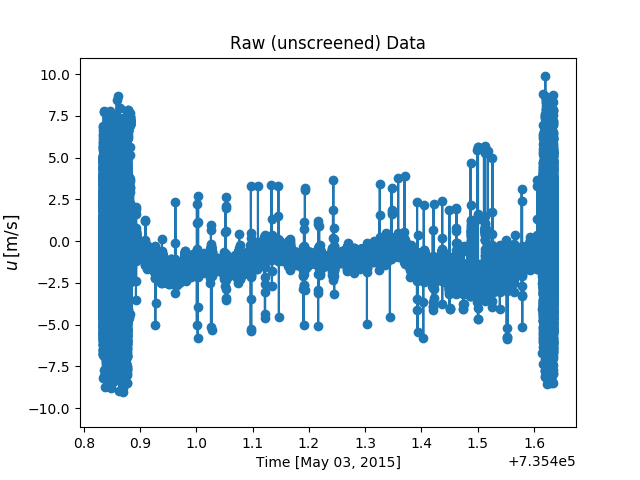

CPU times: user 190 ms, sys: 59 ms, total: 249 ms
Wall time: 615 ms


In [14]:
% matplotlib nbagg
raw_data_plot(dat_raw)

Below, specify the start and end x values of the data so that it can be cropped. You can use the rectangle select tool to zoom in and determine these values. Be sure to add the number in the lower right corner to the desired value, noting that this value changes as you zoom. The home button will return the figure to its original state. 

Note, if you don't think the t_range needs to be changed then don't run the following cell.

In [15]:
x_start = .084 + 7.354008e5
x_end = .014 + 7.354016e5
t_range = [x_start, x_end]
t_range

[735400.8840000001, 735401.614]

Now that a t_range has been specified to crop the data, the unscreened/raw data will be plotted under the screened/cropped data for visulization. 

<IPython.core.display.Javascript object>


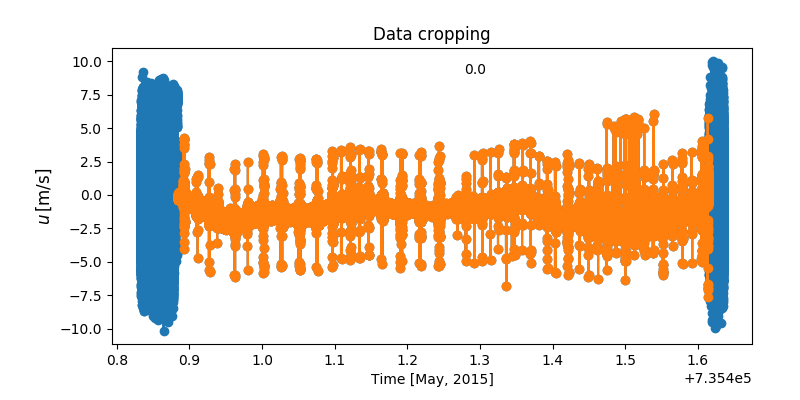

CPU times: user 4.38 s, sys: 577 ms, total: 4.95 s
Wall time: 5.4 s


In [16]:
% matplotlib nbagg
dat_crop, t_range_inds = crop_plot(dat_raw, t_range)

### Cleaning:

Next, the data file must be cleaned from any noise in the signal. The data is cleaned using the Goring+Nikora method. 

In [17]:
dat_cln, dat = clean(t_range_inds, t_range, dat_raw)

CPU times: user 1min 9s, sys: 4.87 s, total: 1min 14s
Wall time: 1min 6s


<IPython.core.display.Javascript object>


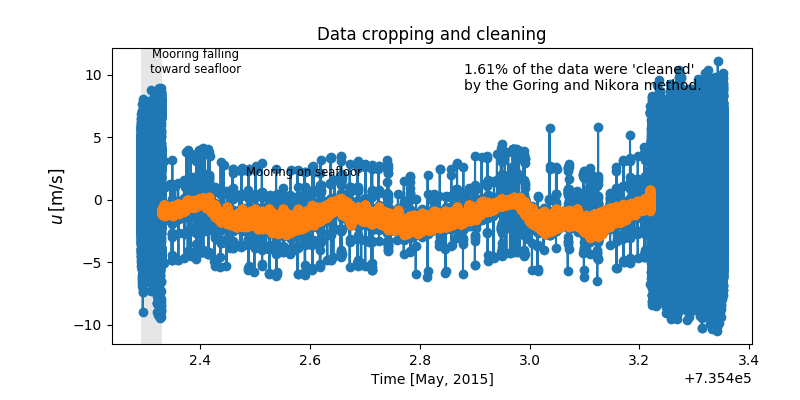

CPU times: user 5.15 s, sys: 128 ms, total: 5.28 s
Wall time: 5.59 s


In [19]:
% matplotlib nbagg
clean_plot(dat_raw, dat_crop, dat, t_range_inds, t_range)

## 4. Motion Correction:
Next, perform motion correction (including rotation into earth frame) in order to account for the movement of the mooring as tracked by the internal motion unit (IMU). The data must also be rotated into the earth frame for comparison to motion correction. It finally must be roated into the principal axes frame. 

In [18]:
dat_crop, dat_cln = motion_correct(dat_crop, accel_filter, dat_cln)

## 5. Turbulence Statistics:
Several graphs can be created to look at the turbulence statistics. 

### Turbulence Spectra:
The first graph looks at the velocity or turbulence spectra over time. 

<IPython.core.display.Javascript object>


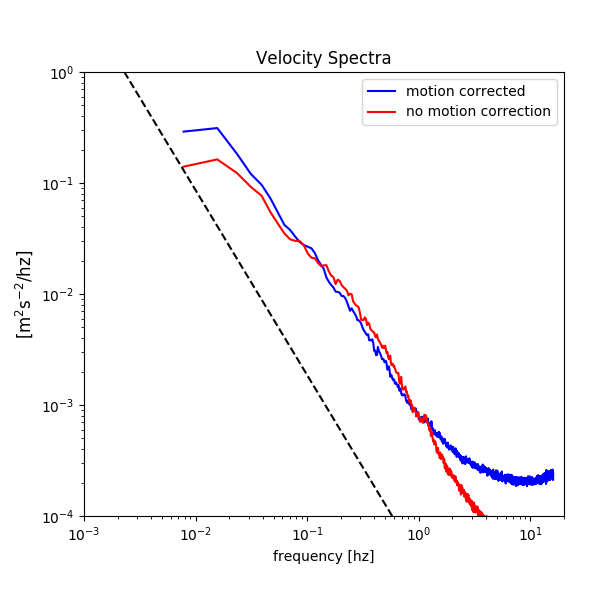

CPU times: user 3.74 s, sys: 847 ms, total: 4.59 s
Wall time: 5.49 s


In [19]:
dat_bin, dat_cln_bin = spectra(dat, dat_cln)

### Turbulent Kinetic Energy Plot:

<IPython.core.display.Javascript object>


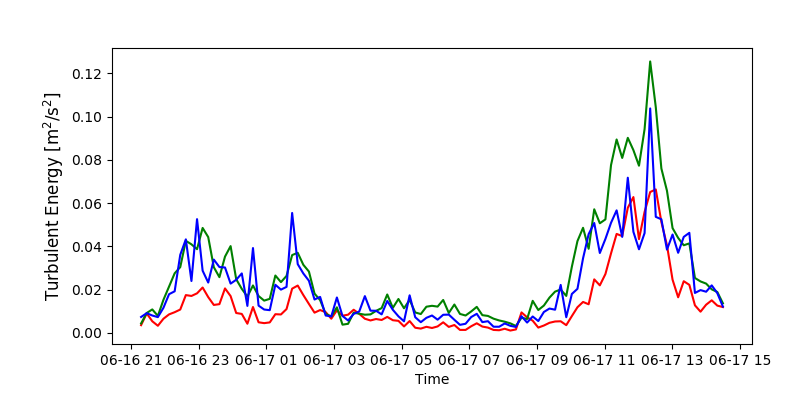

CPU times: user 87.6 ms, sys: 7.89 ms, total: 95.4 ms
Wall time: 135 ms


In [20]:
tke_plot(dat_cln_bin)

### Reynold's Stress Plot:

<IPython.core.display.Javascript object>


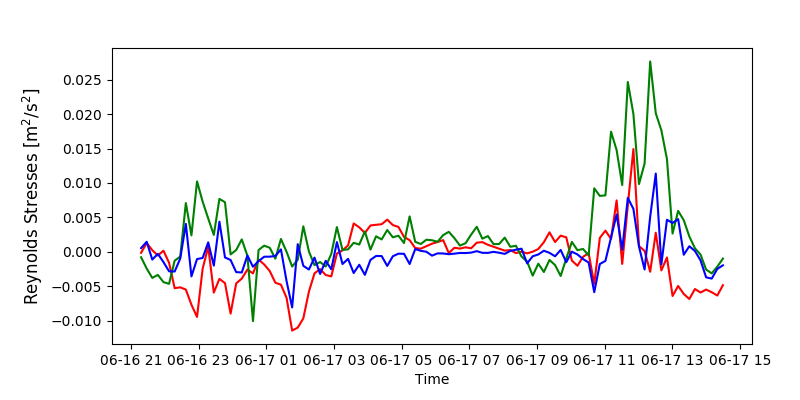

CPU times: user 92.9 ms, sys: 11.7 ms, total: 105 ms
Wall time: 130 ms


In [21]:
reynolds_stress(dat_cln_bin)